# Movie Recommendation System (Restricted Boltzmann Machine)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

%matplotlib inline

We will be using data acquired from Grouplens which contains movies, users and rating by three users. Updated datasets are available, though we will be using this dataset due to its small size.

In [2]:
!wget -O ./data/moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ./data/moviedataset.zip -d ./data

--2019-04-08 18:21:03--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./data/moviedataset.zip’

./data/moviedataset 100%[===================>]   5.64M  1.97MB/s    in 2.9s    

2019-04-08 18:21:06 (1.97 MB/s) - ‘./data/moviedataset.zip’ saved [5917549/5917549]

Archive:  ./data/moviedataset.zip
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [2]:
def get_training_data():
    '''
    Returns (X_train, movies_df, ratings_df, user_rating_df)
    '''
    
    movies_df = pd.read_csv('./data/ml-1m/movies.dat', sep='::', header=None, engine='python')
    ratings_df = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', header=None, engine='python')
    
    movies_df.columns = ['MovieID', 'Title', 'Genres']
    ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    
    user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
    
    norm_user_rating_df = user_rating_df.fillna(0) / 5.0
    X_train = norm_user_rating_df.values
    
    return(X_train, movies_df, ratings_df, user_rating_df)

In [3]:
X_train, movies_df, ratings_df, user_rating_df = get_training_data()

We will create a RBM with 20 hidden nodes and as many visible nodes as number of unique user ratings.

In [4]:
#Initialization
nh = 20
nv = len(user_rating_df.columns)

vb = tf.placeholder("float", [nv]) #placeholders for bias in visible nodes
hb = tf.placeholder("float", [nh]) #placeholders for bias in hidden nodes

W = tf.placeholder("float", [nv, nh]) #weights matrix

In [5]:
#Phase 1: Input

v0 = tf.placeholder("float", [None, nv]) #Initial state of visible layer
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb) #Probability of each hidden unit
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #Drawing samples from hidden units

#Phase 2: Reconstruction

_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) #Calculated probabilities of visible unit
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #Sample v given h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb) #Final hidden layer state

In [6]:
lr = 1.0

#Calculate the Contrastive Divergence to maximize
contr_diverg = (tf.matmul(tf.transpose(v0), h0) - tf.matmul(tf.transpose(v1), h1)) / tf.to_float(tf.shape(v0)[0])

#Create methods to update the weights and biases
update_w = W + lr * contr_diverg
update_vb = vb + lr * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + lr * tf.reduce_mean(h0 - h1, 0)

We will use a mean squared error function for our model.

In [7]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

Initialize variables to hold values for our placeholders.

In [8]:
#Current weight
cur_w = np.zeros([nv, nh], np.float32)
#Current visible unit biases
cur_vb = np.zeros([nv], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([nh], np.float32)

#Previous weight
prv_w = np.zeros([nv, nh], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([nv], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([nh], np.float32)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
epochs = 15
batchsize = 100
errors = []

print("Epoch\tTraining Error")
print("---------------------------------")
for i in range(epochs):
    for start, end in zip(range(0, len(X_train), batchsize), range(batchsize, len(X_train), batchsize)):
        batch = X_train[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        
    errors.append(sess.run(err_sum, feed_dict={v0: X_train, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (i+1, " \t{0:.4f}".format(errors[-1]))
print("---------------------------------")

Epoch	Training Error
---------------------------------
1  	0.0557
2  	0.0472
3  	0.0440
4  	0.0429
5  	0.0423
6  	0.0416
7  	0.0413
8  	0.0410
9  	0.0407
10  	0.0407
11  	0.0405
12  	0.0404
13  	0.0403
14  	0.0402
15  	0.0401
---------------------------------


Plotting the errors for each epoch gives us an insight on the training process.

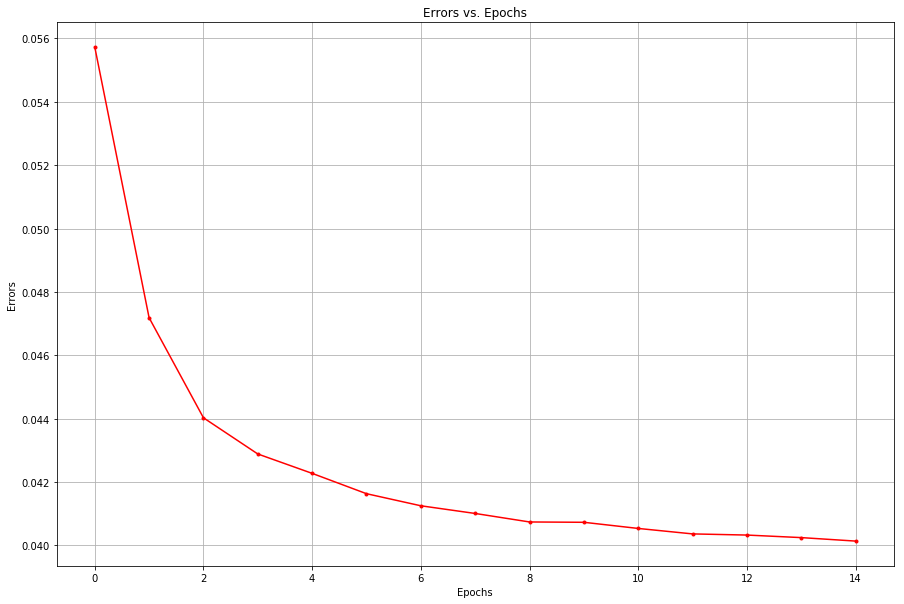

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(errors, 'r.-')
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.title("Errors vs. Epochs")
plt.grid()
plt.show()

In [12]:
def recommend(user_id, movies_df, user_rating_df):
    '''
    This function returns a dataframe of recommendations based on the UserID provided.
    '''
    inputUser = X_train[user_id-1].reshape(1, -1)
    
    hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
    rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

    scored_movies_df = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
    scored_movies_df = scored_movies_df.assign(RecommendationScore = rec[0])
    
    movies_df = ratings_df[ratings_df['UserID'] == user_id]
    
    merged_df = scored_movies_df.merge(movies_df, on='MovieID', how='outer')
    
    merged_df = merged_df.sort_values(["RecommendationScore"], ascending=False)
    
    recommendations = merged_df[pd.isnull(merged_df["UserID"])]
    
    return(recommendations[['MovieID', 'Title', 'Genres', 'RecommendationScore']])

In [13]:
recommendations = recommend(215, movies_df, user_rating_df)

In [14]:
recommendations.head(20)

,MovieID,Title,Genres,RecommendationScore
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.638056
575,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.616520
1148,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.531408
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.335883
1449,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.308204
443,457,"Fugitive, The (1993)",Action|Thriller,0.263527
1178,1270,Back to the Future (1985),Comedy|Sci-Fi,0.256082
1124,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller,0.244721
737,780,Independence Day (ID4) (1996),Action|Sci-Fi|War,0.217832
1110,1200,Aliens (1986),Action|Sci-Fi|Thriller|War,0.209356


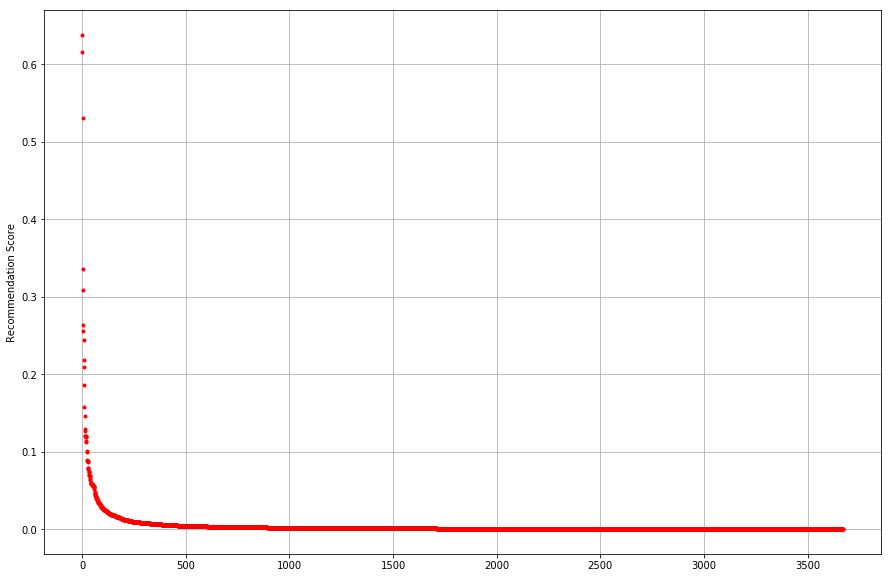

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(recommendations["RecommendationScore"].values, 'r.')
plt.grid()
plt.ylabel("Recommendation Score")
plt.show()

As the recommendation score curve becomes quite flat after a few hundred values, only the highest few values have any considerable difference to be recommended.